# Multi time-series regression basics with skorch

This notebook gives you an example of how to handle multiple time-series regression, especially with recurrent neural networks (RNN) to do grid-search, multi-output and scoring.

First, we will start with a normal regression problem and make it multiple time-series afterwards. We've already covered single valued regressions in our other tutorials so we will directly start with multivariate regression problems.

### What do we mean by 'multiple' here?

Simply that we have several time-series that cannot be mixed. So our data is three-dimensional. An example for this would be a mapping from date to number of pizza orders. 

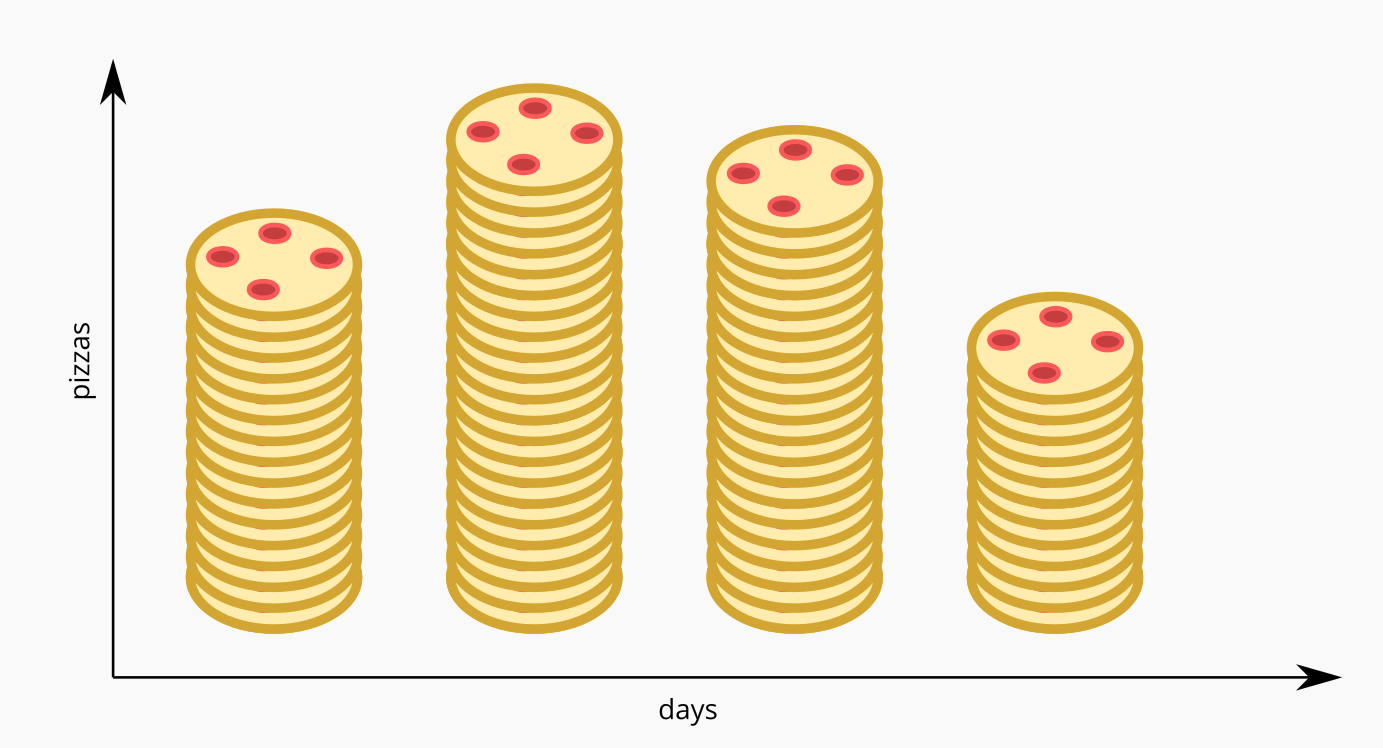

If you want to analyse this data on a per-restaurant basis we will have several of these time-series, e.g.:

- restaurant 1 has 31 days, each having a number of pizza orders
- restaurant 2 has 30 days, each having a number of pizza orders
- etc.

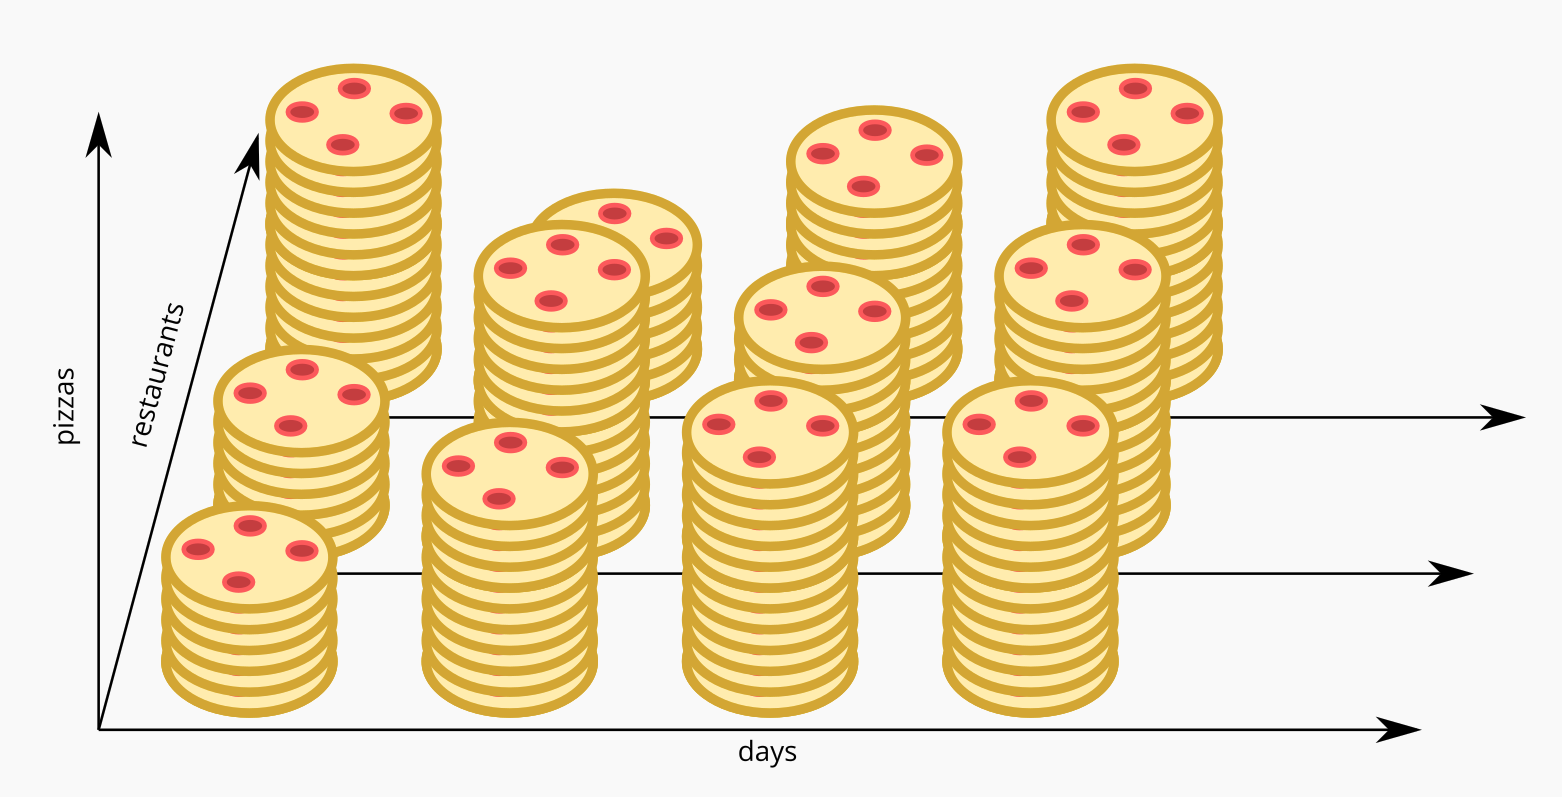

Therefore you end up having something like `(restaurant, day, 1)`. And of course, you could flatten that data structure so that you have `(restaurant * day, 1)` entries but you will lose the per-restaurant information that day 3 may depend on day 2 and so on. So we want to keep this 3d structure and still do our regression.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import skorch.toy
import skorch
import sklearn
import torch

### Warm-up with single time-series + MLP

In [2]:
# single time-series multi regression, one continuous variable X creates for each value of X two values of y
X = np.linspace(0, 10, 10)[:, None].astype(np.float32)
y = np.hstack([X**2, X**3]).astype(np.float32)

assert X.shape == (10, 1)
assert y.shape == (10, 2)

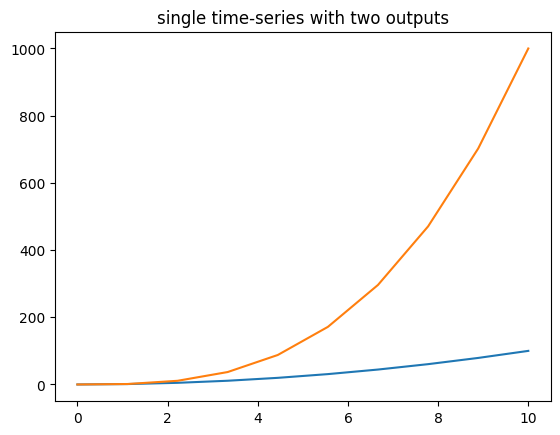

In [3]:
plt.plot(X, y)
plt.title('single time-series with two outputs');

We can fit this data easily with a multi-layer perceptron that has 1 input unit, 10 hidden units and 2 output units.

In [4]:
regressor = skorch.toy.make_regressor(input_units=1, output_units=y.shape[1], hidden_units=10)

In [5]:
net = skorch.NeuralNetRegressor(regressor)

In [6]:
net.fit(X, y)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   116153.6719    10367.6875  0.0343
      2   251081.1562        6.9785  0.0016
      3   117758.6719        7.1916  0.0015
      4   116516.6094       19.6990  0.0015
      5   115299.2656       44.1331  0.0016
      6   114106.1250       80.1349  0.0014
      7   112936.7344      127.3536  0.0014
      8   111790.6172      185.4467  0.0017
      9   110667.3125      254.0796  0.0016
     10   109566.3594      332.9256  0.0014


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=MLPModule(
    (nonlin): ReLU()
    (sequential): Sequential(
      (0): Linear(in_features=1, out_features=10, bias=True)
      (1): ReLU()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=10, out_features=2, bias=True)
    )
  ),
)

We could now do a grid-search of, for example, the `Dropout` layer of our regressor but this is already 
covered in the basics and not worth our time. Let's do multiple time-series instead!

## Multiple time-series with RNNs

Let's create our multiple time-series. Before we simply had one time-series shared between our outputs. Now we have multiple, different X values that map onto 2 y-values each (we've added more restaurants).

In [7]:
# timeful multi regression
getX = lambda i: np.linspace(0+i, 10+i, 10)[None, :, None].astype(np.float32)
X = np.vstack([getX(i) for i in range(10)])
y = np.vstack([
    np.concatenate([Xi[None]**2, Xi[None]*3], axis=-1)
    for Xi in X
])

assert X.shape == (10, 10, 1)
assert y.shape == (10, 10, 2)

#### Plot of the multiple time-series

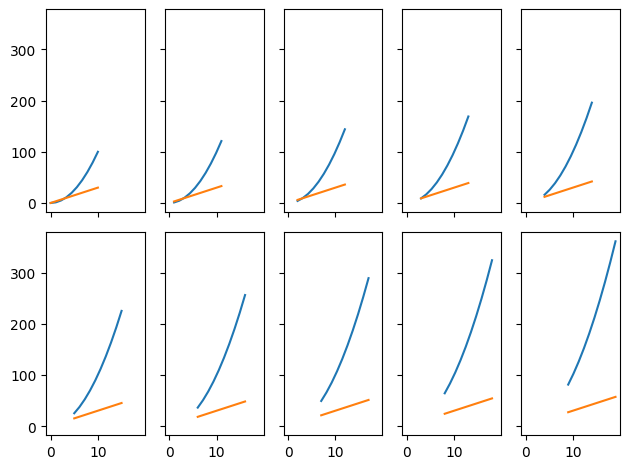

In [8]:
def plot_time_series(X, y):
    fig, subplots = plt.subplots(ncols=5, nrows=2, sharey=True, sharex=True)
    for i in range(X.shape[0]):
        subplots.flatten()[i].plot(X[i], y[i])
    fig.tight_layout()
    
plot_time_series(X, y)

Now we have 10 different time-series where each has two output variables that we want to model.
Let's build a RNN module that can work with this data.

In [9]:
class RNNRegressor(torch.nn.Module):
    def __init__(self, dropout=0.):
        super().__init__()
        self.rnn = torch.nn.LSTM(input_size=1, hidden_size=10, batch_first=True)
        self.rnn.reset_parameters()
        self.dop = torch.nn.Dropout2d(p=dropout)
        self.out = torch.nn.Linear(10, 2)
        self.out.reset_parameters()
        
    def forward(self, X):
        out_rnn, _hid = self.rnn(X)
        out_lin = self.out(out_rnn)
        return out_lin
    
net = skorch.NeuralNetRegressor(RNNRegressor)

We decided do go with an LSTM (no specific reason except for its popularity, GRU or RNN is fine as well).
A few things that are worth noting:

- We used `batch_first=True` since our data has the shape `(time-series, x-axis, y-axis)` and therefore our dimension where we separate the different time-series is dimension 0 (the first dimension). This is also the dimension that will be batched upon by the internal pytorch data loader

- We added a parameter for a dropout layer so that we can grid-search `module__dropout` later on

Let's run a fit on the network to see if everything works:

In [10]:
net.fit(X, y)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    12004.9375     1517.3826  0.0198
      2    11483.4092     1253.2427  0.0022
      3    10620.6445     1008.3934  0.0021
      4     9729.8027      812.7202  0.0021
      5     8905.2021      671.0997  0.0021
      6     8183.6162      572.6593  0.0021
      7     7552.6250      503.8711  0.0021
      8     6999.1108      435.2076  0.0023
      9     6496.4990      819.0521  0.0023
     10     8735.3066      512.0660  0.0021


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=RNNRegressor(
    (rnn): LSTM(1, 10, batch_first=True)
    (dop): Dropout2d(p=0.0, inplace=False)
    (out): Linear(in_features=10, out_features=2, bias=True)
  ),
)

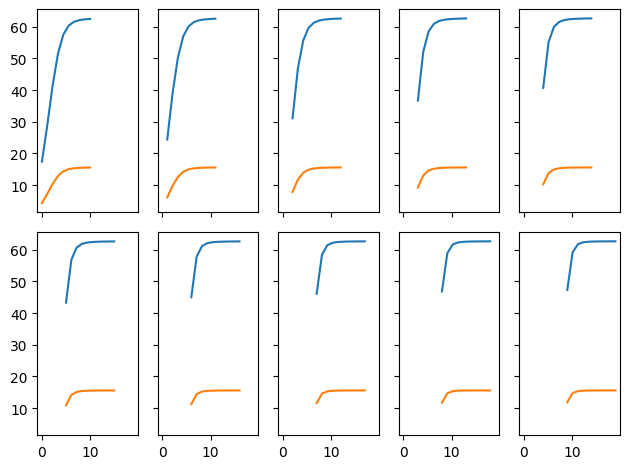

In [11]:
y_pred = net.predict(X)

plot_time_series(X, y_pred)

Well, that is far from a perfect fit but we have to resist the urge to make this work well. This is not about performance, it is about tooling, remember.

- We would love to be able to grid search different parameters. E.g. `module__dropout` and `max_epochs` come to mind

- We are currently using a random validation split for the internal validation split in the network. That is far from optimal

To do grid search and, conincidentally, to have proper internal splits for things such as early stopping, we will need proper data splits. 

So let's look at how to do this!

### Splitting 

Splitting, the method of making a train and validation set from a single set of data, in this
case our `X` and `y`.

The default splitting method for regression problems is `KFold`.
This is true for skorch as well as for sklearn. It is a sensible default but for our case
it is introducing *leakage* and our model will turn out worse if we use this kind of split.

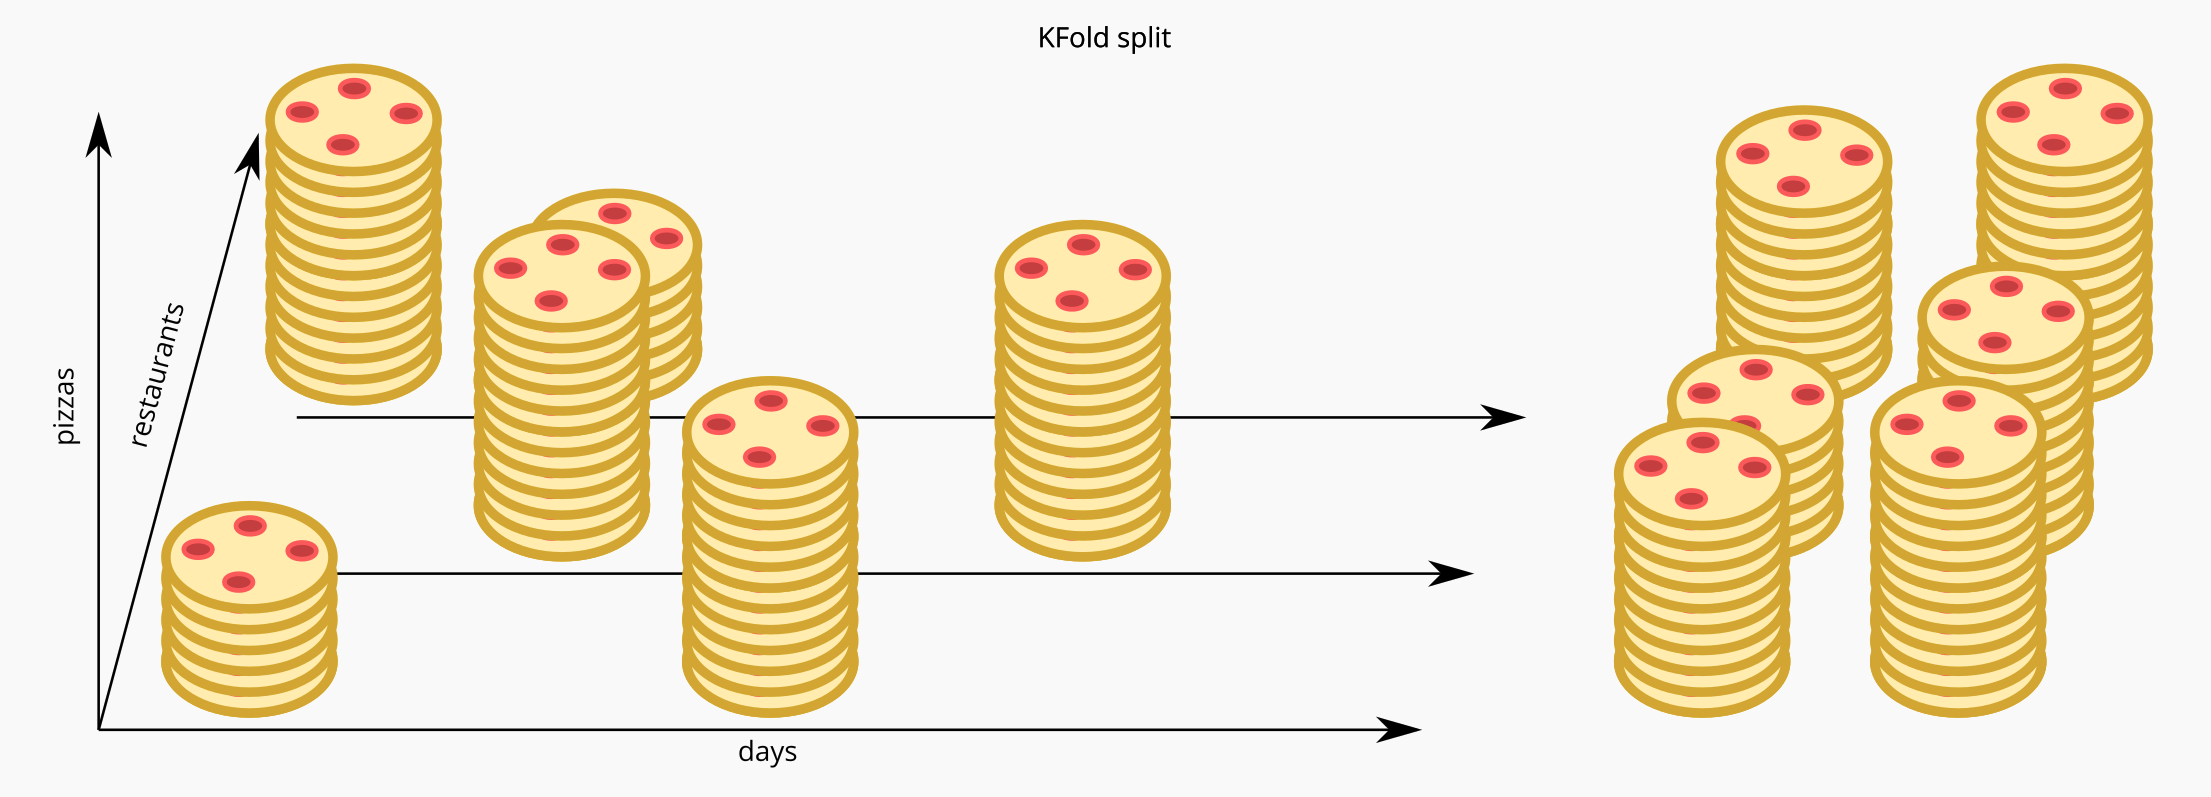

Why? Because we our data has time-dependence and we just randomly pick data across time
we end up with data from the future, mixed with data from the past. That would make it easier
for the model to model the future since it is partially known. It also messes up the serial
nature of our data.

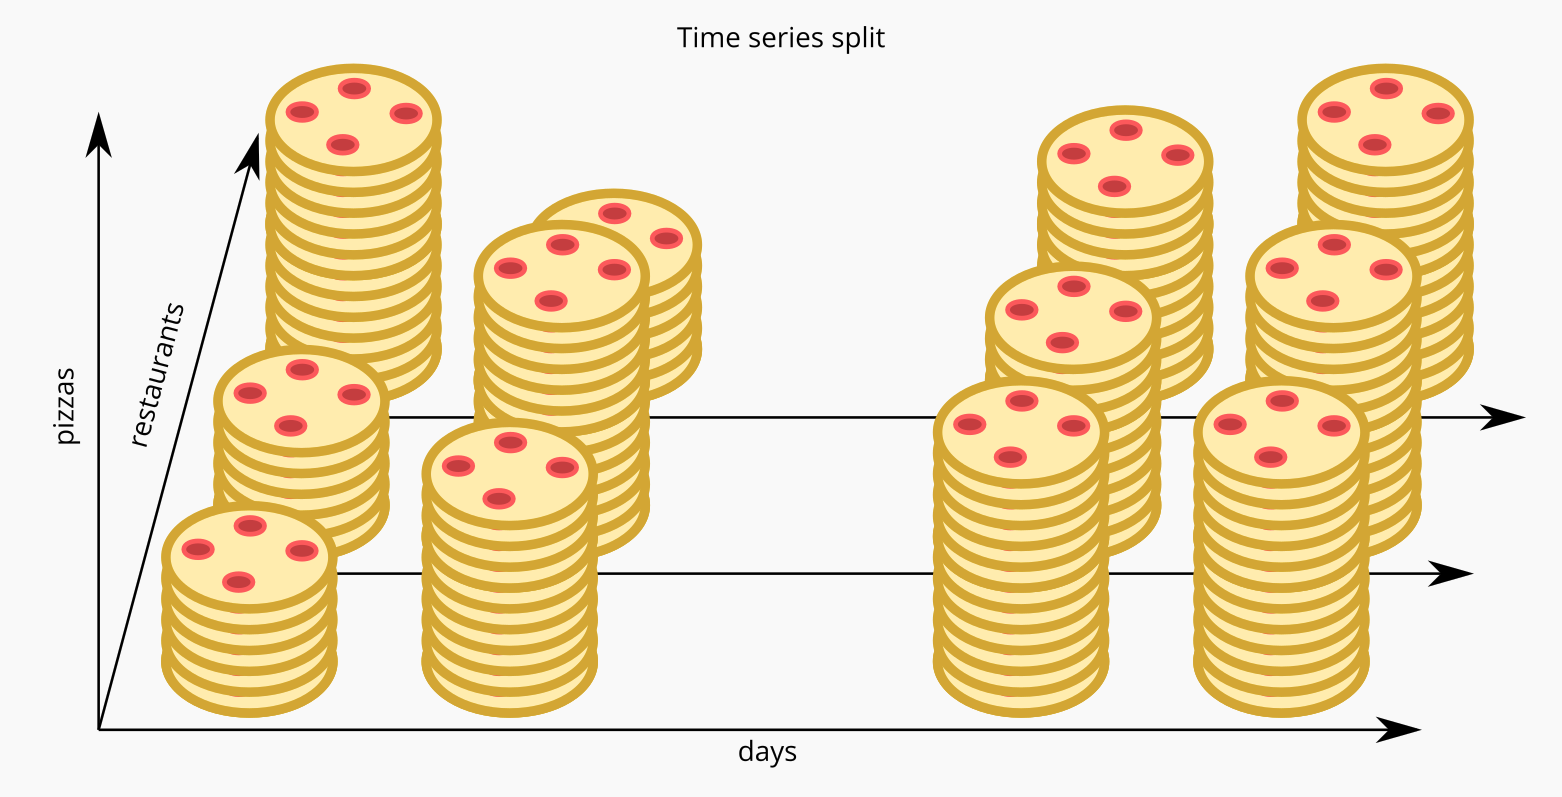

That's why it is necessary to use a time-series split. It will adhere to the serial nature of
our data and the resulting subsets will not leak any data from the future. But let's
look at this in code.

In [12]:
from sklearn.model_selection import KFold

In [13]:
kfold_splitter = KFold(n_splits=3)

In [14]:
list(kfold_splitter.split(X, y))

[(array([4, 5, 6, 7, 8, 9]), array([0, 1, 2, 3])),
 (array([0, 1, 2, 3, 7, 8, 9]), array([4, 5, 6])),
 (array([0, 1, 2, 3, 4, 5, 6]), array([7, 8, 9]))]

As you can see our time-series are torn apart without adhering to the serial nature.

Already the first split will use `X` indices from the *future* and `y` indices from the *past*.
Even worse, the second split will cut out the `y`-values from the middle.
This is problematic as this is not what the model is tasked to do and possibly a lot easier
that our real task of predicting future values, so we're shooting us in the foot twice.

In [15]:
from sklearn.model_selection import TimeSeriesSplit

In [16]:
ts_splitter = TimeSeriesSplit(n_splits=3)

In [17]:
list(ts_splitter.split(X, y))

[(array([0, 1, 2, 3]), array([4, 5])),
 (array([0, 1, 2, 3, 4, 5]), array([6, 7])),
 (array([0, 1, 2, 3, 4, 5, 6, 7]), array([8, 9]))]

`TimeSeriesSplit` on the other hand takes care to only use `y`-values from the future and `X`-values from the past.

#### Using time-series-split for internal validation in skorch

Using the time-series split for internal validation is easy.
Just pass the sklearn splitter to `ValidSplit` and you are done.

Note that `ValidSplit` will just take the first split, since it is not
doing a search operation but simply validation after each epoch. We
would not want different results due to different splits between epochs.

In [18]:
from skorch.dataset import ValidSplit

In [19]:
from skorch.dataset import ValidSplit

net = skorch.NeuralNetRegressor(
    RNNRegressor,
    train_split=ValidSplit(cv=ts_splitter),
)

In [20]:
net.fit(X, y)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     2741.6086     7332.3525  0.0023
      2     2653.2302     7146.8608  0.0020
      3     2554.0322     6928.5967  0.0020
      4     2437.9177     6684.1235  0.0019
      5     2310.5476     6399.4019  0.0019
      6     2166.5566     6075.8022  0.0024
      7     2003.5082     5758.2788  0.0020
      8     1848.0748     5458.4316  0.0019
      9     1705.7537     5181.2153  0.0019
     10     1577.7065     4919.8701  0.0023


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=RNNRegressor(
    (rnn): LSTM(1, 10, batch_first=True)
    (dop): Dropout2d(p=0.0, inplace=False)
    (out): Linear(in_features=10, out_features=2, bias=True)
  ),
)

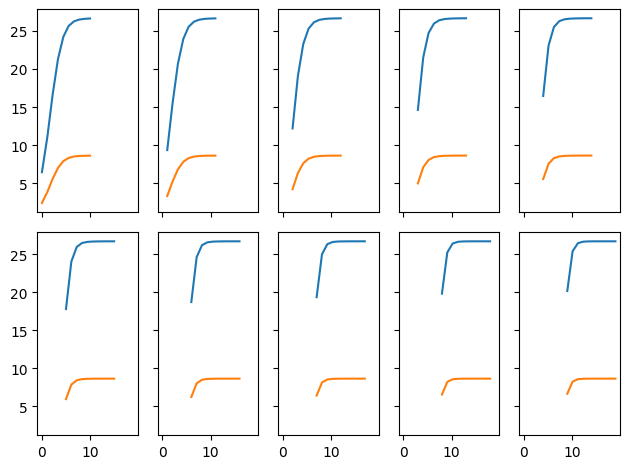

In [21]:
y_pred = net.predict(X)

plot_time_series(X, y_pred)

**Take note** at how different the results look now. They are certainly still bad
predictions but they are a lot **smoother** (because there are no data points missing)
and the validation loss reflects the performance (it is *bad*!) a lot better.

Now we're equipped with the tools to do a grid-search and attempt to improve
the model by tuning hyper-parameters.

## Grid-search with multiple time-series

We've got our splitting sorted out but there's one detail that we need when searching for better parameter combinations: scoring.

The default scorer for regression problems in sklearn is $R^2$ and it can't deal with inputs that have more than 2 dimensions. In fact, many metrics defined by sklearn can't. So we have to deal with this as well.

For mean squared error this is easy as it is a point-wise operation. As long as `y_true` and `y_pred` align, MSE is happy. So in that case, we would simply need to convert our 3d structure into a 2d one and call the MSE metric.

In [22]:
def time_series_mse(y_true, y_pred, **kwargs):
    y_true_2d = y_true.reshape(-1, y_true.shape[-1])
    y_pred_2d = y_pred.reshape(-1, y_pred.shape[-1])
    return sklearn.metrics.mean_squared_error(y_true_2d, y_pred_2d, **kwargs)

However, $R^2$ also incorporates the mean of the predicted values and these can, in our case, differ depending on which time-series we're looking at. So $R^2$ needs to be aware of these. One solution would be to compute the r2
score for each individual time-series and then averaging the result, giving a final score.

However, this is just for the sake of an example, as [you may not want to use $R^2$ in your time-series prediction anyway](https://stats.stackexchange.com/a/101580/49590).

In [23]:
def time_series_r2(y_true, y_pred, **kwargs):
    return np.mean([
        sklearn.metrics.r2_score(y_true[i], y_pred[i], **kwargs) 
        for i in range(y_true.shape[0])
    ])

Now with that out of the way, we can now build up our scorer for the grid search, define our params and search away!

In [24]:
scorer = sklearn.metrics.make_scorer(time_series_mse, greater_is_better=False)

cv = TimeSeriesSplit(n_splits=5)

In [25]:
param_grid={
    'module__dropout': [0, 0.1, 0.2],
    'max_epochs': [5, 10, 15, 20],
}

# make the net silent so that the grid search output is concise
net.set_params(verbose=False);

grid = sklearn.model_selection.GridSearchCV(
    estimator=net, 
    param_grid=param_grid, 
    n_jobs=1, # set to -1 for parallelization
    cv=cv, 
    scoring=scorer, 
    error_score='raise')

grid_result = grid.fit(X, y)

In [26]:
cv_results = pd.DataFrame(grid_result.cv_results_).sort_values(by='rank_test_score')
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_epochs,param_module__dropout,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
10,0.049434,0.002674,0.001075,0.000071,20,0.1,"{'max_epochs': 20, 'module__dropout': 0.1}",-5499.267090,-7665.176270,-9181.182617,-14229.675781,-18630.007812,-11041.061914,4760.810918,1
9,0.048142,0.001997,0.001046,0.000081,20,0,"{'max_epochs': 20, 'module__dropout': 0}",-5801.000977,-6412.314453,-9404.714844,-14513.476562,-20657.710938,-11357.843555,5578.476894,2
11,0.050393,0.002026,0.001080,0.000087,20,0.2,"{'max_epochs': 20, 'module__dropout': 0.2}",-5296.682129,-8243.451172,-8738.119141,-15452.269531,-19893.718750,-11524.848145,5343.895780,3
7,0.036727,0.001325,0.000996,0.000050,15,0.1,"{'max_epochs': 15, 'module__dropout': 0.1}",-5195.110840,-7929.126953,-12051.081055,-14318.735352,-20056.652344,-11910.141309,5159.979473,4
6,0.037157,0.001718,0.001044,0.000089,15,0,"{'max_epochs': 15, 'module__dropout': 0}",-5898.027344,-8986.135742,-11393.519531,-14849.000000,-19577.337891,-12140.804102,4735.377243,5
8,0.039408,0.003281,0.001157,0.000082,15,0.2,"{'max_epochs': 15, 'module__dropout': 0.2}",-5649.611328,-7649.893066,-10862.176758,-16554.246094,-20450.705078,-12233.326465,5521.392505,6
3,0.026143,0.000846,0.001054,0.000066,10,0,"{'max_epochs': 10, 'module__dropout': 0}",-6203.453125,-8808.452148,-10747.494141,-16283.972656,-20811.371094,-12570.948633,5286.160702,7
4,0.023629,0.000181,0.000913,0.000026,10,0.1,"{'max_epochs': 10, 'module__dropout': 0.1}",-6517.182617,-8110.620605,-11047.357422,-16451.845703,-21584.888672,-12742.379004,5568.293715,8
5,0.024391,0.000455,0.001088,0.000130,10,0.2,"{'max_epochs': 10, 'module__dropout': 0.2}",-6629.884766,-8310.145508,-11775.127930,-16968.318359,-21558.548828,-13048.405078,5532.775221,9
0,0.014678,0.000314,0.001160,0.000053,5,0,"{'max_epochs': 5, 'module__dropout': 0}",-7283.103516,-10311.452148,-13847.206055,-18267.687500,-23563.945312,-14654.678906,5766.881546,10


## The end

And this concludes this tutorial on basic handling of multiple time-series data with multiple outputs.

We saw that it is possible and easy to use RNN and skorch with this type of data.
We were able to use the sklearn tooling effectively and ran the sklearn grid search
while taking care that our data is well split and we're not fooling ourselves
with wrong scores.

And in the end we got smoother and better results.

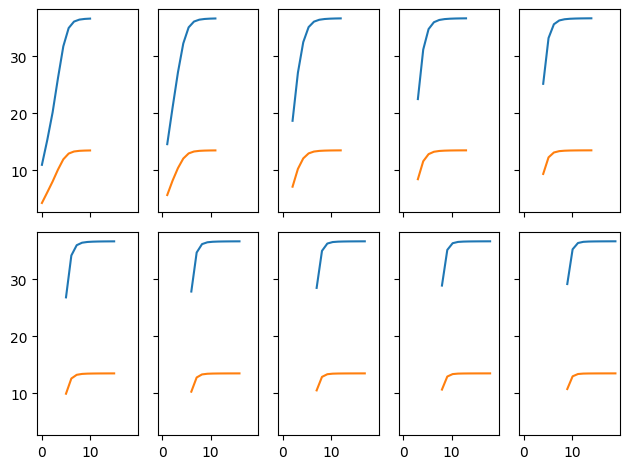

In [27]:
y_pred = grid_result.best_estimator_.predict(X)

plot_time_series(X, y_pred)